In [1]:
import matplotlib.pyplot as plt
from forse.tools.nn_tools import *
from forse.tools.img_tools import *
from forse.tools.mix_tools import *
import healpy as hp
from forse.networks.dcgan import *
from mypy import *

Using TensorFlow backend.


In [2]:
repo_dir = '/global/u1/k/krach/maps_repo/'
hfi012 = hp.read_map(repo_dir+'HFI_SkyMap_353-psb-field-IQU_2048_R3.00_full_smt0.2deg.fits')
hfi1 = hp.read_map(repo_dir+'HFI_SkyMap_353-psb-field-IQU_2048_R3.00_full_smt1.0deg.fits')
hfi5 = hp.read_map(repo_dir+'HFI_SkyMap_353-psb-field-IQU_2048_R3.00_full_smt5.0deg.fits')

/global/homes/k/krach/usr/python_prefix_3.7/lib/python3.7/site-packages/healpy/fitsfunc.py:352: UserWarning: If you are not specifying the input dtype and using the default np.float64 dtype of read_map(), please consider that it will change in a future version to None as to keep the same dtype of the input file: please explicitly set the dtype if it is important to you.
  "If you are not specifying the input dtype and using the default "


NSIDE = 2048
ORDERING = RING in fits file
INDXSCHM = IMPLICIT
NSIDE = 2048
ORDERING = RING in fits file
INDXSCHM = IMPLICIT
NSIDE = 2048
ORDERING = RING in fits file
INDXSCHM = IMPLICIT


In [3]:
repo_dir = '/global/homes/k/krach/scratch/NNforFG/maps/'
pysm5 = hp.read_map(repo_dir+'PySM_dust_T_nside2048_fwhm5.fits')*1e-6/Kcmb_Krj(353.)
pysm1 = hp.read_map(repo_dir+'PySM_dust_T_nside2048_fwhm1.fits')*1e-6/Kcmb_Krj(353.)
pysm12 = hp.read_map(repo_dir+'PySM_dust_T_nside2048_fwhm0.12.fits')*1e-6/Kcmb_Krj(353.)

NSIDE = 2048
ORDERING = RING in fits file
INDXSCHM = IMPLICIT
NSIDE = 2048
ORDERING = RING in fits file
INDXSCHM = IMPLICIT
NSIDE = 2048
ORDERING = RING in fits file
INDXSCHM = IMPLICIT


In [4]:
dcgan = DCGAN(output_directory='/global/homes/k/krach/scratch/NNforFG/DCGAN/tests/ratio/', img_size=(64, 64))

In [5]:
def smooth_accuracy(y_true, y_pred):
        return K.mean(K.equal(K.round(y_true), K.round(y_pred)))

In [6]:
dir_models = '/global/homes/k/krach/scratch/NNforFG/DCGAN/tests/ratio/models/pswap_10/'
#dir_models = '/global/homes/k/krach/scratch/NNforFG/DCGAN/opt/210120_adam09/models/'
#dir_models = '/global/homes/k/krach/scratch/NNforFG/DCGAN/opt/lat20/models/'
#dcgan.discriminator = load_model(dir_models+'discrim_99999.h5')
dcgan.generator = load_model(dir_models+'generat_99999.h5')
#dcgan.discriminator = load_model(dir_models+'discrim_5000.h5', custom_objects={'smooth_accuracy': smooth_accuracy})
#dcgan.generator = load_model(dir_models+'generat_99999.h5', custom_objects={'smooth_accuracy': smooth_accuracy})

/global/homes/k/krach/usr/python_prefix_3.7/lib/python3.7/site-packages/keras/engine/saving.py:384: UserWarning: Error in loading the saved optimizer state. As a result, your model is starting with a freshly initialized optimizer.
  warnings.warn('Error in loading the saved optimizer '


In [7]:
Npix = 320
patch_dim = 20
reso_amin = patch_dim*60./Npix
sizepatch = reso_amin/60.

In [8]:
header = set_header(30, -20, sizepatch, Npix)

In [9]:
patch_hfi1L = h2f(hfi1, header)
patch_hfi_012 = h2f(hfi012, header)

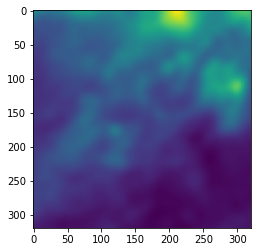

In [10]:
plt.imshow(patch_hfi1L)

In [11]:
patch_pysm_012 = h2f(pysm12, header)
patch_pysm_1 = h2f(pysm1, header)

In [12]:
images_oversamp = divide_image(patch_hfi1L, 32, 64)
images_ss_oversamp = divide_image(patch_hfi_012/patch_hfi1L, 32, 64)
images_pysm_oversamp = divide_image(patch_pysm_012/patch_pysm_1, 32, 64)
Xos = np.array(images_oversamp[0])
indx = images_oversamp[2]
weights = images_oversamp[1]

In [13]:
for i in range(Xos.shape[0]):
    Xos[i] = rescale_min_max(Xos[i])
Xos = Xos.reshape(Xos.shape[0], 64, 64, 1)
gen_imgs_os = dcgan.generator.predict(Xos)

In [14]:
nn_images_oversamp = np.copy(images_oversamp)
nn_images_oversamp[0] = gen_imgs_os[:, :, :, 0]
for i in range(len(nn_images_oversamp[0])):
    #nn_images_oversamp[0][i] = (rescale_min_max_back(nn_images_oversamp[0][i], [res_min, res_max]))
    nn_images_oversamp[0][i] = (rescale_min_max_back(nn_images_oversamp[0][i], 
                                    [np.min(images_pysm_oversamp[0][i]), np.max(images_pysm_oversamp[0][i])]))

In [15]:
NN_small_scale_apo = apodize_and_unify_images(nn_images_oversamp)

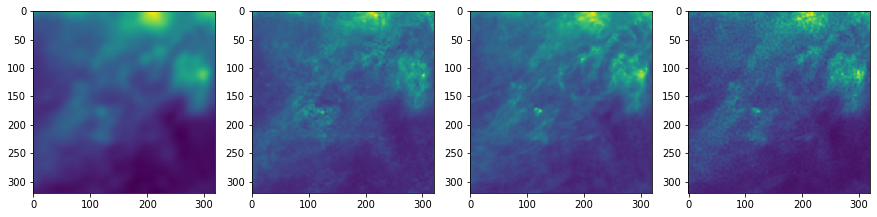

In [16]:
plt.figure(figsize=(15, 8))
plt.subplot(141)
plt.imshow(patch_hfi1L)
plt.subplot(142)
plt.imshow(NN_small_scale_apo*patch_hfi1L,vmin=0)
plt.subplot(143)
plt.imshow(patch_hfi_012, vmin=0)
plt.subplot(144)
plt.imshow(patch_pysm_012, vmin=0)

In [17]:
training_path = '/global/homes/k/krach/scratch/NNforFG/training_set/'
training_file_ss = 'training_set_1000patches_4x4deg_T_HR12amin_LR1deg_Npix64_lat10.npy'
X_train_ss, X_test_ss, Y_train_ss, Y_test_ss = load_training_set(training_path+training_file_ss)

In [18]:
training_path = '/global/homes/k/krach/scratch/NNforFG/training_set/'
training_file_ls = 'training_set_1000patches_20x20deg_T_HR1deg_LR5deg_Npix64_lat10.npy'
X_train_ls, X_test_ls, Y_train_ls, Y_test_ls = load_training_set(training_path+training_file_ls)

In [19]:
test_nn = dcgan.generator.predict(X_test_ss)

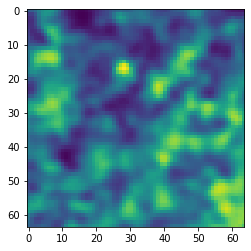

In [20]:
plt.imshow(test_nn[100,:,:,0])

In [21]:
rhos_1deg, f_1deg, u_1deg, chi_1deg = [], [], [], []    
rhos_12a, f_12a, u_12a, chi_12a = [], [], [], []  
for i in range(200):
    rhos_1, f_1, u_1, chi_1 = get_functionals(Y_test_ss[i, :, :, 0])
    rhos_12, f_12, u_12, chi_12= get_functionals(Y_test_ls[i, :, :, 0])
    f_1deg.append(f_1)
    f_12a.append(f_12)
    u_1deg.append(u_1)
    u_12a.append(u_12)
    chi_1deg.append(chi_1)
    chi_12a.append(chi_12)

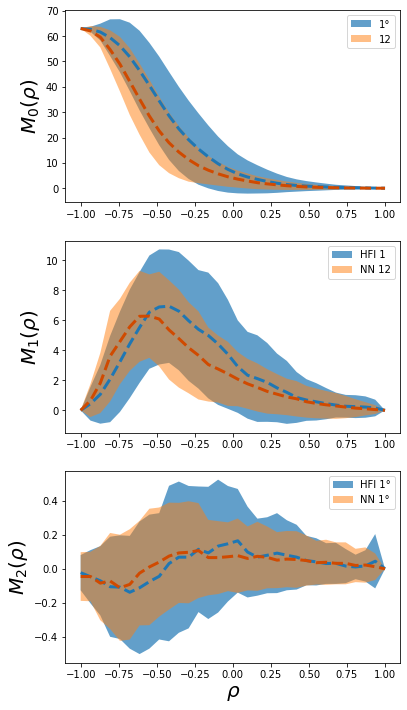

In [22]:
f_1deg = np.array(f_1deg)
f_12a = np.array(f_12a)
u_1deg = np.array(u_1deg)
u_12a = np.array(u_12a)
chi_1deg = np.array(chi_1deg)
chi_12a = np.array(chi_12a)
plt.figure(figsize=(6, 12))
plt.subplot(311)
plt.ylabel(r'$M_0(\rho$)', fontsize=20)


plt.fill_between(rhos_1, 
                     np.mean(f_1deg, axis=0)-np.std(f_1deg, axis=0), 
                     np.mean(f_1deg, axis=0)+np.std(f_1deg, axis=0), 
                     lw=1, label='1°', alpha=0.7)
plt.plot(rhos_1, np.mean(f_1deg, axis=0), lw=3, ls='--')
plt.fill_between(rhos_12, 
                     np.mean(f_12a, axis=0)-np.std(f_12a, axis=0), 
                     np.mean(f_12a, axis=0)+np.std(f_12a, axis=0), 
                     lw=1, label='12', alpha=0.5)
plt.plot(rhos_12, np.mean(f_12a, axis=0), lw=3, ls='--', color='#D04A00')
plt.legend()
plt.subplot(312)
plt.ylabel(r'$M_1(\rho$)', fontsize=20)


plt.fill_between(rhos_1, 
                     np.mean(u_1deg, axis=0)-np.std(u_1deg, axis=0), 
                     np.mean(u_1deg, axis=0)+np.std(u_1deg, axis=0), 
                     lw=1, label='HFI 1', alpha=0.7)
plt.plot(rhos_1, np.mean(u_1deg, axis=0), lw=3, ls='--')
plt.fill_between(rhos_12, 
                     np.mean(u_12a, axis=0)-np.std(u_12a, axis=0), 
                     np.mean(u_12a, axis=0)+np.std(u_12a, axis=0), 
                     lw=1, label='NN 12', alpha=0.5)
plt.plot(rhos_12, np.mean(u_12a, axis=0), lw=3, ls='--', color='#D04A00')



plt.legend()
plt.subplot(313)
plt.fill_between(rhos_1, 
                     np.mean(chi_1deg, axis=0)-np.std(chi_1deg, axis=0), 
                     np.mean(chi_1deg, axis=0)+np.std(chi_1deg, axis=0), 
                     lw=1, label='HFI 1°', alpha=0.7)
plt.plot(rhos_1, np.mean(chi_1deg, axis=0), lw=3, ls='--')
plt.ylabel(r'$M_1(\rho$)', fontsize=20)



plt.fill_between(rhos_12, 
                     np.mean(chi_12a, axis=0)-np.std(chi_12a, axis=0), 
                     np.mean(chi_12a, axis=0)+np.std(chi_12a, axis=0), 
                     lw=1, label='NN 1°', alpha=0.5)
plt.plot(rhos_12, np.mean(chi_12a, axis=0), lw=3, ls='--', color='#D04A00')
plt.xlabel(r'$\rho$', fontsize=20)
plt.ylabel(r'$M_2(\rho$)', fontsize=20)

plt.legend()

In [23]:
patch_path = '/global/homes/k/krach/scratch/NNforFG/training_set/'
#Ys, Xs = np.load(patch_path+'training_set_PySM_1000patches_20x20deg_T_HR1deg_LR5deg_Npix64_set2.npy')
Yl, Xl = np.load(patch_path+'training_set_PySM_100patches_20x20deg_T_HR1deg_LR5deg_Npix320_lat30.npy')
Yl_zoom = np.zeros((1000, 64, 64))
X_edges = []
for i in range(40):
    j = i
    Yl_zoom[i*25:(i+1)*25] = divide_image(Yl[j], 64, 64)[0]
X = Yl_zoom
for i in range(X.shape[0]):
    X[i], Xmin, Xmax = rescale_min_max(X[i], return_min_max=True)
    X_edges.append([Xmin, Xmax])
x_test, x_test2 = split_training_set(X)
X_edges = np.array(X_edges)    

In [24]:
gen_imgs_test = dcgan.generator.predict(x_test)

In [25]:
pysm_ss, pysm_1d = np.load(patch_path+'training_set_PySM_100patches_20x20deg_T_HR12amin_LR1deg_Npix320_lat30.npy')

In [26]:
pysm_ss_zoom = np.zeros((1000, 64, 64))
pysm_1d_zoom = np.zeros((1000, 64, 64))
pysm_ss_edges = []
for i in range(0, 40):
    j = i+40
    pysm_ss_zoom[i*25:(i+1)*25] = divide_image(pysm_ss[j], 64, 64)[0]
    pysm_1d_zoom[i*25:(i+1)*25] = divide_image(pysm_1d[j], 64, 64)[0]
for i in range(1000):
    ratio = pysm_ss_zoom/pysm_1d_zoom
    pysm_ss_edges.append([ratio[i].min(), ratio[i].max()])
pysm_ss_edges = np.array(pysm_ss_edges)

In [27]:
bnormed_gen = np.copy(gen_imgs_test)
for i in range(800):
    bnormed_gen[i] = (rescale_min_max_back(gen_imgs_test[i], [np.mean(pysm_ss_edges[i,0]), np.mean(pysm_ss_edges[i,1])]))

In [28]:
a = 175
b = a+25
NN_small_scale = unify_images(bnormed_gen[a:b])
large_scale = pysm_1d[int(a/25)]
small_scale = pysm_ss[int(a/25)]

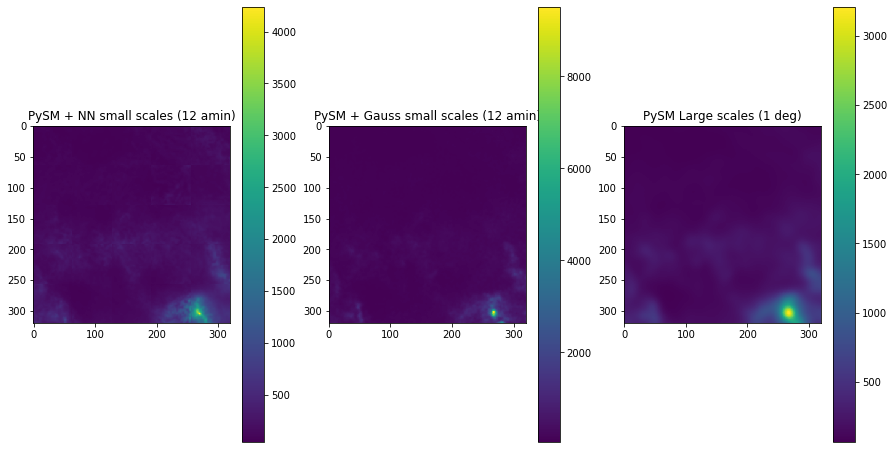

In [29]:
plt.figure(figsize=(15, 8))
plt.subplot(131)
plt.imshow(NN_small_scale*large_scale)
plt.colorbar()
plt.title('PySM + NN small scales (12 amin)')
plt.subplot(132)
plt.imshow(small_scale)
plt.colorbar()
plt.title('PySM + Gauss small scales (12 amin)')
plt.subplot(133)
plt.imshow(large_scale)
plt.title('PySM Large scales (1 deg)')
plt.colorbar()

In [30]:
images_oversamp = divide_image(large_scale, 32, 64)
Xos = np.array(images_oversamp[0])
indx = images_oversamp[2]
weights = images_oversamp[1]

In [31]:
for i in range(Xos.shape[0]):
    Xos[i] = rescale_min_max(Xos[i])
Xos = Xos.reshape(Xos.shape[0], 64, 64, 1)
gen_imgs_os = dcgan.generator.predict(Xos)

In [32]:
nn_images_oversamp = np.copy(images_oversamp)
nn_images_oversamp[0] = gen_imgs_os[:, :, :, 0]
for i in range(len(nn_images_oversamp[0])):
    nn_images_oversamp[0][i] = (rescale_min_max_back(nn_images_oversamp[0][i], [np.mean(pysm_ss_edges[:,0]), np.mean(pysm_ss_edges[:,1])]))

In [33]:
NN_small_scale_apo = apodize_and_unify_images(nn_images_oversamp)

In [34]:
hfi_ss, hfi_1d = np.load(patch_path+'training_set_100patches_20x20deg_T_HR12amin_LR1deg_Npix320_lat30.npy')

In [35]:
hfi_small_scale = hfi_ss[int(a/25)]
hfi_large_scale = hfi_1d[int(a/25)]

Text(0.5, 1.0, 'Gauss small scales (12 amin)')

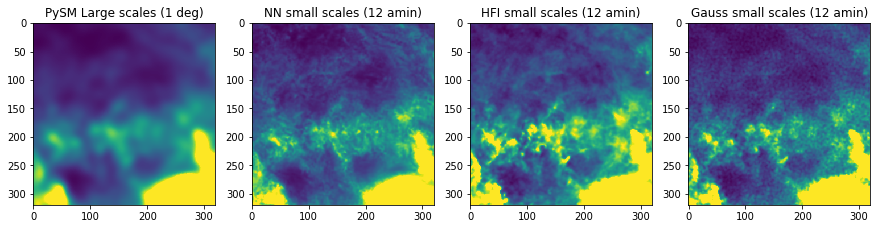

In [36]:
f = 1/Kcmb_Krj(353.)*1e-6
plt.figure(figsize=(15, 8))
plt.subplot(141)
plt.imshow(large_scale*f, vmax=0.005)
plt.title('PySM Large scales (1 deg)')
plt.subplot(142)
plt.imshow(NN_small_scale_apo*large_scale*f, vmax=0.005)
#plt.colorbar()
plt.title('NN small scales (12 amin)')
plt.subplot(143)
plt.imshow(hfi_small_scale, vmax=0.005)
#plt.colorbar()
plt.title('HFI small scales (12 amin)')
plt.subplot(144)
plt.imshow(small_scale*f, vmax=0.005)
#plt.colorbar()
plt.title('Gauss small scales (12 amin)')

In [37]:
large_scale_tot = []
small_scale_tot = []
NN_small_scale_tot = []
rhos_nn_ss, f_nn_ss, u_nn_ss, chi_nn_ss = [], [], [], [] 
rhos_pysm_ss, f_pysm_ss, u_pysm_ss, chi_pysm_ss = [], [], [], [] 
rhos_hfi_ss, f_hfi_ss, u_hfi_ss, chi_hfi_ss = [], [], [], []
for s in range(100):
    large_scale = pysm_1d[int(s)]
    small_scale = pysm_ss[int(s)]
    hfi_small_scale = hfi_ss[int(s)]
    hfi_large_scale = hfi_1d[int(s)]
    images_oversamp = divide_image(large_scale, 64, 64)
    images_oversamp_ss = divide_image(small_scale, 64, 64)
    images_oversamp_hfi = divide_image(hfi_large_scale, 64, 64)
    images_oversamp_hfi_ss = divide_image(hfi_small_scale, 64, 64)
    Xos = np.array(images_oversamp[0])
    indx = images_oversamp[2]
    weights = images_oversamp[1]
    for i in range(Xos.shape[0]):
        ratio_oversamp_ss = np.array(images_oversamp_ss[0][i])/np.array(images_oversamp[0][i])
        ratio_oversamp_ss = rescale_min_max(ratio_oversamp_ss)
        ratio_oversamp_hfi_ss = np.array(images_oversamp_hfi_ss[0][i])/np.array(images_oversamp_hfi[0][i])
        ratio_oversamp_hfi_ss = rescale_min_max(ratio_oversamp_hfi_ss)
        rhos_pysm_ss, f_PYSM, u_PYSM, chi_PYSM= get_functionals(ratio_oversamp_ss)
        rhos_hfi_ss, f_hfi, u_hfi, chi_hfi= get_functionals(ratio_oversamp_hfi_ss)
        f_pysm_ss.append(f_PYSM)
        u_pysm_ss.append(u_PYSM)
        chi_pysm_ss.append(chi_PYSM)
        f_hfi_ss.append(f_hfi)
        u_hfi_ss.append(u_hfi)
        chi_hfi_ss.append(chi_hfi)
        Xos[i] = rescale_min_max(Xos[i])
    Xos = Xos.reshape(Xos.shape[0], 64, 64, 1)
    gen_imgs_os = dcgan.generator.predict(Xos)
    nn_images_oversamp = np.copy(images_oversamp)
    nn_images_oversamp[0] = gen_imgs_os[:, :, :, 0]
    for i in range(len(nn_images_oversamp[0])):
        nn_images_oversamp_scal = rescale_min_max(nn_images_oversamp[0][i])
        rhos_nn_ss, f_NN, u_NN, chi_NN= get_functionals(nn_images_oversamp_scal)
        f_nn_ss.append(f_NN)
        u_nn_ss.append(u_NN)
        chi_nn_ss.append(chi_NN)
        nn_images_oversamp[0][i] = (rescale_min_max_back(nn_images_oversamp[0][i], [np.mean(pysm_ss_edges[:,0]), np.mean(pysm_ss_edges[:,1])]))
    NN_small_scale_apo = apodize_and_unify_images(nn_images_oversamp)
    large_scale_tot.append(large_scale)
    small_scale_tot.append(small_scale/large_scale)
    NN_small_scale_tot.append(NN_small_scale_apo)

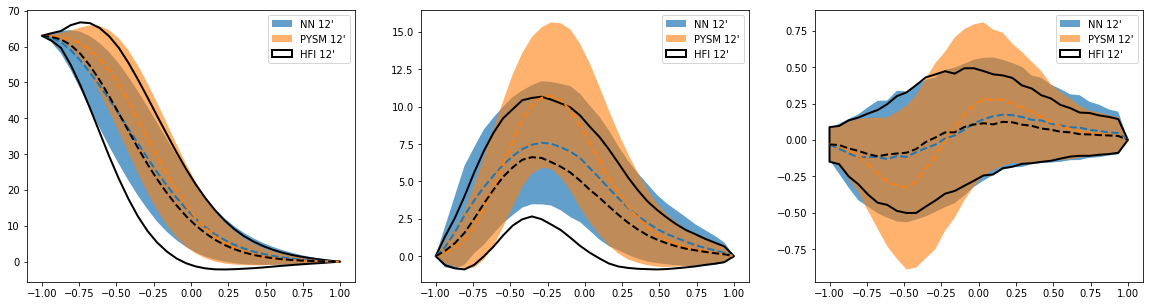

In [38]:
f_nn_ss = np.array(f_nn_ss)
u_nn_ss = np.array(u_nn_ss)
chi_nn_ss = np.array(chi_nn_ss)
f_pysm_ss = np.array(f_pysm_ss)
u_pysm_ss = np.array(u_pysm_ss)
chi_pysm_ss = np.array(chi_pysm_ss)
f_hfi_ss = np.array(f_hfi_ss)
u_hfi_ss = np.array(u_hfi_ss)
chi_hfi_ss = np.array(chi_hfi_ss)
plt.figure(figsize=(20, 5))
plt.subplot(131)
plt.fill_between(rhos_nn_ss, 
                     np.mean(f_nn_ss, axis=0)-np.std(f_nn_ss, axis=0), 
                     np.mean(f_nn_ss, axis=0)+np.std(f_nn_ss, axis=0), 
                     lw=1, label="NN 12'", alpha=0.7)
plt.plot(rhos_nn_ss, np.mean(f_nn_ss, axis=0), lw=2, ls='--')


plt.fill_between(rhos_pysm_ss, 
                     np.mean(f_pysm_ss, axis=0)-np.std(f_pysm_ss, axis=0), 
                     np.mean(f_pysm_ss, axis=0)+np.std(f_pysm_ss, axis=0), 
                     label="PYSM 12'", alpha=0.6)
plt.plot(rhos_pysm_ss, np.mean(f_pysm_ss, axis=0), lw=2, ls='--')


plt.fill_between(rhos_hfi_ss, 
                     np.mean(f_hfi_ss, axis=0)-np.std(f_hfi_ss, axis=0), 
                     np.mean(f_hfi_ss, axis=0)+np.std(f_hfi_ss, axis=0), 
                     lw=2, ls='-', label="HFI 12'", edgecolor='black', facecolor='')
plt.plot(rhos_hfi_ss, np.mean(f_hfi_ss, axis=0), color='black', lw=2, ls='--')


plt.legend()
plt.subplot(132)
plt.fill_between(rhos_nn_ss, 
                     np.mean(u_nn_ss, axis=0)-np.std(u_nn_ss, axis=0), 
                     np.mean(u_nn_ss, axis=0)+np.std(u_nn_ss, axis=0), 
                     lw=1, label="NN 12'", alpha=0.7)
plt.plot(rhos_nn_ss, np.mean(u_nn_ss, axis=0), lw=2, ls='--')
plt.fill_between(rhos_pysm_ss, 
                     np.mean(u_pysm_ss, axis=0)-np.std(u_pysm_ss, axis=0), 
                     np.mean(u_pysm_ss, axis=0)+np.std(u_pysm_ss, axis=0), 
                     label="PYSM 12'", alpha=0.6)
plt.plot(rhos_pysm_ss, np.mean(u_pysm_ss, axis=0), lw=2, ls='--')


plt.fill_between(rhos_hfi_ss, 
                     np.mean(u_hfi_ss, axis=0)-np.std(u_hfi_ss, axis=0), 
                     np.mean(u_hfi_ss, axis=0)+np.std(u_hfi_ss, axis=0), 
                     lw=2, ls='-', label="HFI 12'", edgecolor='black', facecolor='')
plt.plot(rhos_hfi_ss, np.mean(u_hfi_ss, axis=0), color='black', lw=2, ls='--')


plt.legend()
plt.subplot(133)
plt.fill_between(rhos_nn_ss, 
                     np.mean(chi_nn_ss, axis=0)-np.std(chi_nn_ss, axis=0), 
                     np.mean(chi_nn_ss, axis=0)+np.std(chi_nn_ss, axis=0), 
                     lw=1, label="NN 12'", alpha=0.7)
plt.plot(rhos_nn_ss, np.mean(chi_nn_ss, axis=0), lw=2, ls='--')
plt.fill_between(rhos_pysm_ss, 
                     np.mean(chi_pysm_ss, axis=0)-np.std(chi_pysm_ss, axis=0), 
                     np.mean(chi_pysm_ss, axis=0)+np.std(chi_pysm_ss, axis=0), 
                     label="PYSM 12'", alpha=0.6)
plt.plot(rhos_pysm_ss, np.mean(chi_pysm_ss, axis=0), lw=2, ls='--')
plt.fill_between(rhos_hfi_ss, 
                     np.mean(chi_hfi_ss, axis=0)-np.std(chi_hfi_ss, axis=0), 
                     np.mean(chi_hfi_ss, axis=0)+np.std(chi_hfi_ss, axis=0), 
                     lw=2, ls='-', label="HFI 12'", edgecolor='black', facecolor='')
plt.plot(rhos_hfi_ss, np.mean(chi_hfi_ss, axis=0), color='black', lw=2, ls='--')
plt.legend()



In [39]:
m1 = compute_intersection(rhos_hfi_ss, 
                     [np.mean(f_hfi_ss, axis=0)-np.std(f_hfi_ss, axis=0), np.mean(f_hfi_ss, axis=0)+np.std(f_hfi_ss, axis=0)], 
                     [np.mean(f_nn_ss, axis=0)-np.std(f_nn_ss, axis=0),np.mean(f_nn_ss, axis=0)+np.std(f_nn_ss, axis=0)], 
                     npt=100000)
m2 = compute_intersection(rhos_hfi_ss, 
                     [np.mean(u_hfi_ss, axis=0)-np.std(u_hfi_ss, axis=0), np.mean(u_hfi_ss, axis=0)+np.std(u_hfi_ss, axis=0)], 
                     [np.mean(u_nn_ss, axis=0)-np.std(u_nn_ss, axis=0),np.mean(u_nn_ss, axis=0)+np.std(u_nn_ss, axis=0)], 
                     npt=100000)
m3 = compute_intersection(rhos_hfi_ss, 
                     [np.mean(chi_hfi_ss, axis=0)-np.std(chi_hfi_ss, axis=0), np.mean(chi_hfi_ss, axis=0)+np.std(chi_hfi_ss, axis=0)], 
                     [np.mean(chi_nn_ss, axis=0)-np.std(chi_nn_ss, axis=0),np.mean(chi_nn_ss, axis=0)+np.std(chi_nn_ss, axis=0)], 
                     npt=100000)

In [40]:
print(m1, m2, m3)

0.7932204944727306 0.7426910656620022 0.8530112283089486


In [41]:
large_scale_tot = []
small_scale_tot = []
HFI_tot = []
NN_tot = []
f = 1/Kcmb_Krj(353.)*1e-6
for a in range(100):
    #b = a+25
    large_scale = pysm_1d[int(a)]
    small_scale = pysm_ss[int(a)]
    hfi_small_scale = hfi_ss[int(a)]
    images_oversamp = divide_image(large_scale, 32, 64)
    Xos = np.array(images_oversamp[0])
    indx = images_oversamp[2]
    weights = images_oversamp[1]
    for i in range(Xos.shape[0]):
        Xos[i] = rescale_min_max(Xos[i])
        Xos = Xos.reshape(Xos.shape[0], 64, 64, 1)
        gen_imgs_os = dcgan.generator.predict(Xos)
    nn_images_oversamp = np.copy(images_oversamp)
    nn_images_oversamp[0] = gen_imgs_os[:, :, :, 0]
    for i in range(len(nn_images_oversamp[0])):
        nn_images_oversamp[0][i] = (
            rescale_min_max_back(nn_images_oversamp[0][i], 
            [np.mean(pysm_ss_edges[:,0]), np.mean(pysm_ss_edges[:,1])]))
    NN_small_scale_apo = apodize_and_unify_images(nn_images_oversamp)
    large_scale_tot.append(large_scale*f)
    small_scale_tot.append(small_scale*f)
    HFI_tot.append(hfi_small_scale)
    NN_tot.append(NN_small_scale_apo*large_scale*f)

In [42]:
large_scale_tot = np.array(large_scale_tot)
small_scale_tot = np.array(small_scale_tot)
HFI_tot = np.array(HFI_tot)
NN_tot = np.array(NN_tot)

In [43]:
np.savez('/global/homes/k/krach/scratch/NNforFG/DCGAN/tests/store/maps_patch_first.npz', 
            LSmap = large_scale_tot, SSmap = small_scale_tot, NNmap = NN_tot, HFImap = HFI_tot)

In [232]:
np.arange(0, 10000, 1000)

array([   0, 1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000])